# Analyze Output of Ped Sim
(Assume Ped Sim Output is in parallel folder to the hapsburg git folder

In [1]:
import numpy as np
import os as os
import sys as sys
import multiprocessing as mp
import pandas as pd
import socket
import matplotlib.pyplot as plt

### Do the Arial 
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the default
rcParams['font.sans-serif'] = ['Arial']  # Make sure to have the font installed (it is on cluster for Harald)

### Pick the right path (whether on cluster or at home)
socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
elif socket_name.startswith("Harald-Laptop"):
    print("Midway jnovmbre partition detected.")
    path = "/home/hringbauer/git/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)

sys.path.append("./package/")  # Go to the hapsburg package directory

from hapsburg.PackagesSupport.pp_individual_roh_csvs import post_process_roh_df, combine_ROH_df
from hapsburg.figures.plot_bars import plot_panel_row, prepare_dfs_plot, create_cousins_roh

print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

Harald-Laptop-X1
Midway jnovmbre partition detected.
/home/hringbauer/git/HAPSBURG
CPU Count: 8


### Code to run pedsim
Run in shell:  
`./ped-sim -d example/roh_1st_cousin.def -m refined_mf.simmap -o output/c1 --intf interfere/nu_p_campbell.tsv`  
`./ped-sim -d example/roh_2nd_cousin.def -m refined_mf.simmap -o output/c2 --intf interfere/nu_p_campbell.tsv`  
`./ped-sim -d example/roh_3rd_cousin.def -m refined_mf.simmap -o output/c3 --intf interfere/nu_p_campbell.tsv`


### Funtion to load and process data

In [6]:
def load_segment_file(path_segments="../ped-sim/output/output.seg",
                      roh_only=False, cm_fac=0.01):
    """Load and return segment File of IBD & ROH blocks.
    Return Pandas dataframe. 
    roh_only: Only load ROH blocks
    cm_fac: Factor with which to multiply genetic length columns"""
    df = pd.read_csv(path_segments, sep="\t", header=None)
    df.columns = ["iid1", "iid2", "ch", "Start", "End", 
                  "ibd_stat", "StartM", "EndM", "lengthM"]
    df["length"] = (df["End"] - df["Start"])
    
    for col in ["StartM", "EndM", "lengthM"]:
        df[col] = df[col] * cm_fac
        
    if roh_only:
        df = extract_roh_df(df)
    return df

def extract_roh_df(df, col="ibd_stat", stat="HBD"):
    """Extract and return Dataframe of ROH segments 
    in hapsburg format"""
    df = df[df[col]==stat]
    df = df.drop(columns="iid2")
    df = df.rename(columns={"iid1": "iid"})
    return df

def to_hapsburg_df(path_segments = "../ped-sim/output/test.seg", clst="1st_cousin",
                   savepath = "",
                   min_cm=[4, 8, 12, 20], snp_cm=100,
                   gap=0.5, min_len1=2, min_len2=4,
                   output=False, sort=True):
    """Load pd_sim output and post_process into Hapsburg
    Summary output. Return this dataframe.
    If savepath is given, save to there (tab-seperated)"""
    
    df1 = load_segment_file(path_segments, roh_only=True)  # Load the full segment file, transfomred

    ### Split up into lists of Dataframes
    grouped = df1.groupby(['iid'])
    df_rohs = [x[1] for x in list(grouped)] 
    iids = [x[0] for x in list(grouped)]
    
    df_roh = combine_ROH_df(df_rohs, iids=iids, pops=clst, 
             min_cm=min_cm, snp_cm=snp_cm,
             gap=gap, min_len1=min_len1, min_len2=min_len2,
             output=output, sort=sort)
    
    if len(savepath)>0:
        df1.to_csv(savepath, sep="\t", index=False)
        print(f"Saved to: {savepath}")    
    return df_roh

### Convert to hapsburg Formats
Do first, second and third cousins

In [4]:
%%time
df1 = to_hapsburg_df(path_segments = "../ped-sim/output/c1.seg", 
                     clst="1st_cousin", savepath="./Empirical/c1.tsv")
df1["age"] = 0
df1["clst"] = df2["pop"]

Saved to: ./Empirical/c1.tsv
CPU times: user 35.9 s, sys: 22.5 ms, total: 36 s
Wall time: 35.9 s


In [11]:
%%time
df2 = to_hapsburg_df(path_segments = "../ped-sim/output/c2.seg", 
                     clst="2nd_cousin", savepath="./Empirical/c2.tsv")
df2["age"]=0
df2["clst"]=df2["pop"]

Saved to: ./Empirical/c2.tsv
CPU times: user 14.5 s, sys: 4 ms, total: 14.5 s
Wall time: 14.5 s


In [14]:
%%time
df3 = to_hapsburg_df(path_segments = "../ped-sim/output/c3.seg", 
                     clst="3rd_cousin", savepath="./Empirical/c3.tsv")
df3["age"]=0
df3["clst"]=df2["pop"]

Saved to: ./Empirical/c3.tsv
CPU times: user 7.52 s, sys: 15 µs, total: 7.52 s
Wall time: 7.51 s


In [20]:
df3

,iid,pop,max_roh,sum_roh>4,n_roh>4,sum_roh>8,n_roh>8,sum_roh>12,n_roh>12,sum_roh>20,n_roh>20,age,clst
60,c316_g6-b1-i1,3rd_cousin,46.987332,129.154033,4,122.152084,3,122.152084,3,122.152084,3,0,3rd_cousin
126,c3255_g6-b1-i1,3rd_cousin,40.047005,105.922978,6,95.620342,4,85.111709,3,65.350868,2,0,3rd_cousin
31,c3135_g6-b1-i1,3rd_cousin,55.854785,93.537235,4,87.949511,3,87.949511,3,75.906556,2,0,3rd_cousin
294,c3472_g6-b1-i1,3rd_cousin,38.966725,91.931643,6,74.043190,3,74.043190,3,60.167024,2,0,3rd_cousin
38,c3144_g6-b1-i1,3rd_cousin,36.718880,91.053187,6,91.053187,6,49.136966,2,36.718880,1,0,3rd_cousin
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,c3259_g6-b1-i1,3rd_cousin,0.000000,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0,3rd_cousin
14,c3114_g6-b1-i1,3rd_cousin,0.000000,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0,3rd_cousin
170,c3308_g6-b1-i1,3rd_cousin,0.000000,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0,3rd_cousin
66,c3175_g6-b1-i1,3rd_cousin,0.000000,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0,3rd_cousin


# Show the Barplots

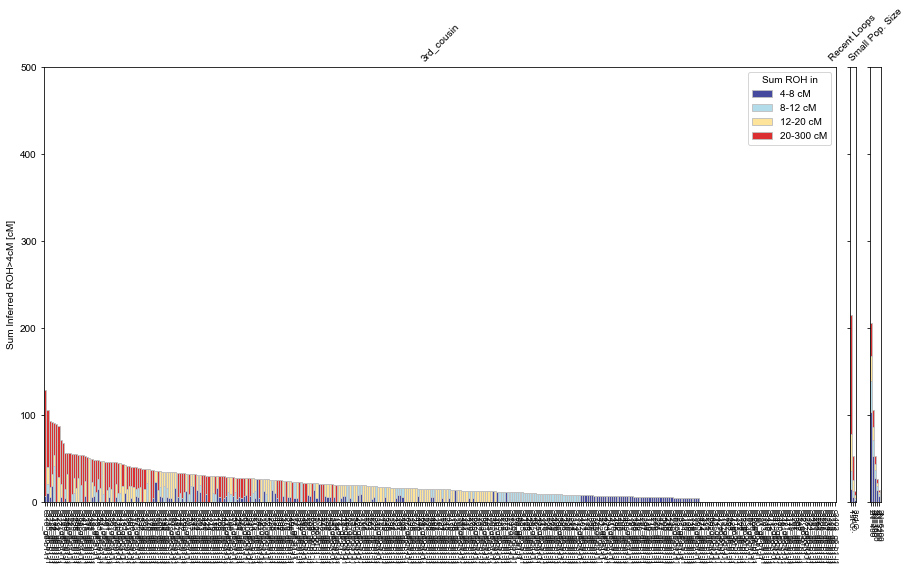

In [19]:
#plot_dfs =prepare_dfs_plot(df3, cms=[4,8,12,20])
plot_panel_row([df3], ylim=[0,500],
               figsize=(15,8), r_title=45,
               savepath="", 
               leg_pos=-1)  # ./figures_test/1st_cousin_ped_sim.pdf

### Plot Distributions of Cousins

In [33]:
def plot_distributions_roh(df, cm1=8, cm2=12, 
                           xlim=[0, 200],
                           lw = 3, c = "silver",
                           degree=2,
                           bins=np.linspace(0, 400, 50)):
    """Plot Distribution of ROH in specific class"""
    
    if cm2>0:
        cousin_means = create_cousins_roh(degrees=[degree],
                                      bins=[[cm1/100, cm2/100]])[0][0] * 100
        y = df[f"sum_roh>{cm1}"] - df[f"sum_roh>{cm2}"]
    else: 
        cousin_means = create_cousins_roh(degrees=[degree],
                                      bins=[[cm1/100, 3.0]])[0][0] * 100
        y = df[f"sum_roh>{cm1}"]

    plt.figure()
    ax=plt.gca()
    
    ax.hist(y, bins, 
            ec="k", zorder=0, color=c)
    if cm2>0:
        ax.set_title(f"Sum ROH {cm1} - {cm2} cM for parents being degree {degree} Cousins")
    else:
        ax.set_title(f"Sum ROH >{cm1} cM for parents being degree {degree} Cousins")
        
    ax.set_xlabel("cM")
    
    if cm2>0:
        ax.set_ylabel(f"Count ROH blocks {cm1}-{cm2} cM")
    else:
        ax.set_ylabel(f"Count ROH blocks >{cm1} cM")
        
    ax.axvline(cousin_means, zorder=1, lw=lw, c="green", 
               label="Theoretical Mean")
    ax.axvline(np.mean(y), zorder=1, lw=lw, c="k", 
               label="Observed Mean")
    ax.set_xlim(xlim)
    ax.legend(loc="upper right")

    plt.show()

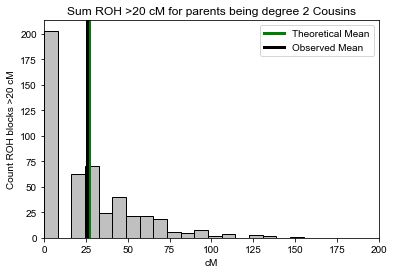

In [56]:
plot_distributions_roh(df2, cm1=20, cm2=0,
                       degree=2,
                       xlim=[0, 200],
                       lw = 3, c = "silver")

# Do statistics on Distributions

### Area 51

In [81]:
df

Min SNPs per cM> 60: 1435/1435
> 4 cM: 1127/1435


In [85]:
np.sum(df2["sum_roh>20"]>50)

88